In [2]:
using Pkg
Pkg.status()
using SymPy
using BenchmarkTools, LinearAlgebra, LazyArrays, BandedMatrices
using PyPlot

      Status `~/.julia/environments/v1.7/Project.toml`
  [aae01518] BandedMatrices v0.17.0
  [6e4b80f9] BenchmarkTools v1.3.1
  [8e7c35d0] BlockArrays v0.16.18
  [336ed68f] CSV v0.10.4
  [ce91de38] ColorBitstring v0.1.1
  [35d6a980] ColorSchemes v3.19.0
  [a93c6f00] DataFrames v1.3.4
  [28b8d3ca] GR v0.64.4
  [7073ff75] IJulia v1.23.3
  [b964fa9f] LaTeXStrings v1.3.0
  [5078a376] LazyArrays v0.22.10
  [a3b82374] MatrixFactorizations v0.9.1
  [91a5bcdd] Plots v1.29.0
  [f27b6e38] Polynomials v3.1.4
  [438e738f] PyCall v1.93.1
  [d330b81b] PyPlot v2.10.0
  [295af30f] Revise v3.3.3
  [f8ebbe35] SemiseparableMatrices v0.3.3
  [3cc68bcd] SetRounding v0.2.1
  [24249f21] SymPy v1.1.6
  [ade2ca70] Dates
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [8dfed614] Test


In [2]:
function ppl(context)
    println(sympy.latex(context))
end

ppl (generic function with 1 method)

In [3]:
xx0 = symbols("x_(1:6)", real=True)
yy0 = symbols("y_(1:6)", real=True)
uu0 = symbols("u_(1:6)", real=True)
vv0 = symbols("v_(1:6)", real=True)
pp0 = symbols("p_(1:6)", real=True)
qq0 = symbols("q_(1:6)", real=True)
xs = [i for i in xx0]
ys = [i for i in yy0]
us = [i for i in uu0]
vs = [i for i in vv0]
ps = [i for i in pp0]
qs = [i for i in qq0]

xf = rand(6)
yf = rand(6);

In [4]:
Ss = triu(xs * ys', 1) + tril(ys * xs')

5×5 Matrix{Sym}:
 x₁⋅y₁  x₁⋅y₂  x₁⋅y₃  x₁⋅y₄  x₁⋅y₅
 x₁⋅y₂  x₂⋅y₂  x₂⋅y₃  x₂⋅y₄  x₂⋅y₅
 x₁⋅y₃  x₂⋅y₃  x₃⋅y₃  x₃⋅y₄  x₃⋅y₅
 x₁⋅y₄  x₂⋅y₄  x₃⋅y₄  x₄⋅y₄  x₄⋅y₅
 x₁⋅y₅  x₂⋅y₅  x₃⋅y₅  x₄⋅y₅  x₅⋅y₅

In [5]:
display(triu(us * vs'))
display(tril(ps * qs'))
triu(us * vs') * tril(ps * qs')

5×5 Matrix{Sym}:
 u₁⋅v₁  u₁⋅v₂  u₁⋅v₃  u₁⋅v₄  u₁⋅v₅
       0  u₂⋅v₂  u₂⋅v₃  u₂⋅v₄  u₂⋅v₅
       0        0  u₃⋅v₃  u₃⋅v₄  u₃⋅v₅
       0        0        0  u₄⋅v₄  u₄⋅v₅
       0        0        0        0  u₅⋅v₅

5×5 Matrix{Sym}:
 p₁⋅q₁        0        0        0        0
 p₂⋅q₁  p₂⋅q₂        0        0        0
 p₃⋅q₁  p₃⋅q₂  p₃⋅q₃        0        0
 p₄⋅q₁  p₄⋅q₂  p₄⋅q₃  p₄⋅q₄        0
 p₅⋅q₁  p₅⋅q₂  p₅⋅q₃  p₅⋅q₄  p₅⋅q₅

5×5 Matrix{Sym}:
 p₁⋅q₁⋅u₁⋅v₁ + p₂⋅q₁⋅u₁⋅v₂ + p₃⋅q₁⋅u₁⋅v₃ + p₄⋅q₁⋅u₁⋅v₄ + p₅⋅q₁⋅u₁⋅v₅  …  p₅⋅q₅⋅u₁⋅v₅
                   p₂⋅q₁⋅u₂⋅v₂ + p₃⋅q₁⋅u₂⋅v₃ + p₄⋅q₁⋅u₂⋅v₄ + p₅⋅q₁⋅u₂⋅v₅     p₅⋅q₅⋅u₂⋅v₅
                                     p₃⋅q₁⋅u₃⋅v₃ + p₄⋅q₁⋅u₃⋅v₄ + p₅⋅q₁⋅u₃⋅v₅     p₅⋅q₅⋅u₃⋅v₅
                                                       p₄⋅q₁⋅u₄⋅v₄ + p₅⋅q₁⋅u₄⋅v₅     p₅⋅q₅⋅u₄⋅v₅
                                                                         p₅⋅q₁⋅u₅⋅v₅     p₅⋅q₅⋅u₅⋅v₅

In [6]:
triu(xs * ys') * tril(ys * xs')

5×5 Matrix{Sym}:
 x_1^2*y_1^2 + x_1^2*y_2^2 + x_1^2*y_3^2 + x_1^2*y_4^2 + x_1^2*y_5^2  …  x_1*x_5*y_5^2
       x_1*x_2*y_2^2 + x_1*x_2*y_3^2 + x_1*x_2*y_4^2 + x_1*x_2*y_5^2     x_2*x_5*y_5^2
                       x_1*x_3*y_3^2 + x_1*x_3*y_4^2 + x_1*x_3*y_5^2     x_3*x_5*y_5^2
                                       x_1*x_4*y_4^2 + x_1*x_4*y_5^2     x_4*x_5*y_5^2
                                                       x_1*x_5*y_5^2       x_5^2*y_5^2

In [7]:
Sf = triu(xf * yf', 1) + tril(yf * xf')
rank(Sf)

6

In [8]:
inv(Sf)

6×6 Matrix{Float64}:
  4.82007      -3.20865       4.19526e-17  …  -9.05962e-17   2.67993e-16
 -3.20865      -0.980123      2.20869          1.61353e-18   1.81847e-17
  3.08659e-17   2.20869      -0.00367193      -1.15888e-16   1.38312e-16
 -2.03374e-16  -1.49441e-16  -2.29194          3.70812       6.13729e-17
 -2.43071e-16   1.47952e-16   5.22825e-16      3.74044      -4.64825
  2.85933e-16  -1.03743e-16  -1.85044e-16  …  -4.64825       5.24061

In [9]:
Tridiagonal(inv(Sf))

6×6 Tridiagonal{Float64, Vector{Float64}}:
  4.82007  -3.20865     ⋅            ⋅          ⋅         ⋅ 
 -3.20865  -0.980123   2.20869       ⋅          ⋅         ⋅ 
   ⋅        2.20869   -0.00367193  -2.29194     ⋅         ⋅ 
   ⋅         ⋅        -2.29194     -0.392611   3.70812    ⋅ 
   ⋅         ⋅          ⋅           3.70812    3.74044  -4.64825
   ⋅         ⋅          ⋅            ⋅        -4.64825   5.24061

In [10]:
isposdef(Tridiagonal(inv(Sf)))

false

In [11]:
n = 6
A = Tridiagonal(rand(n,n))
T = Matrix(A + A' + 100*I)
isposdef(T)
C = cholesky(T)
L = C.L
U = C.U
L * L' ≈ T
U' * U ≈ T

true

In [12]:
include("backsub.jl")
include("invBiU.jl")

invBidiagUxy (generic function with 1 method)

In [13]:
U

6×6 UpperTriangular{Float64, Matrix{Float64}}:
 10.0771   0.0689894   0.0         0.0          0.0         0.0
   ⋅      10.0008      0.0565751   0.0          0.0         0.0
   ⋅        ⋅         10.0145      0.00692577   0.0         0.0
   ⋅        ⋅           ⋅         10.0063       0.0944234   0.0
   ⋅        ⋅           ⋅           ⋅          10.0127      0.0194731
   ⋅        ⋅           ⋅           ⋅            ⋅         10.0734

In [14]:
Uinv, xU, yU = invBidiagUxy(U)
Uinv * U ≈ I
Uinv

6×6 Matrix{Float64}:
 0.0992346  -0.000684559   3.86729e-6   …   2.52423e-11  -4.87964e-14
 0.0         0.099992     -0.000564887     -3.68708e-9    7.12759e-12
 0.0         0.0           0.0998553        6.51767e-7   -1.25995e-9
 0.0         0.0           0.0             -0.00094244    1.82185e-6
 0.0         0.0           0.0              0.0998728    -0.000193067
 0.0         0.0           0.0          …   0.0           0.0992717

In [15]:
L

6×6 LowerTriangular{Float64, Matrix{Float64}}:
 10.0771       ⋅           ⋅            ⋅           ⋅           ⋅ 
  0.0689894  10.0008       ⋅            ⋅           ⋅           ⋅ 
  0.0         0.0565751  10.0145        ⋅           ⋅           ⋅ 
  0.0         0.0         0.00692577  10.0063       ⋅           ⋅ 
  0.0         0.0         0.0          0.0944234  10.0127       ⋅ 
  0.0         0.0         0.0          0.0         0.0194731  10.0734

In [16]:
Linv0, xL, yL = invBidiagUxy(L')
Linv = Linv0'
Linv * L ≈ I
Linv

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
  0.0992346     0.0           0.0         …   0.0          0.0
 -0.000684559   0.099992      0.0             0.0          0.0
  3.86729e-6   -0.000564887   0.0998553       0.0          0.0
 -2.67671e-9    3.90981e-7   -6.91139e-5      0.0          0.0
  2.52423e-11  -3.68708e-9    6.51767e-7      0.0998728    0.0
 -4.87964e-14   7.12759e-12  -1.25995e-9  …  -0.000193067  0.0992717

In [17]:
# S = triu(xU * yU', 1) + tril(yL * xL')

In [18]:
xL == xU
yL == yU

true

In [19]:
Tinv = Uinv * Linv
# Tinv ≈ triu(xU * yU') * tril(yL * xL')
# Tinv - Tinv'

6×6 Matrix{Float64}:
  0.00984798   -6.84526e-5    3.8617e-7    …   2.52102e-12  -4.8441e-15
 -6.84526e-5    0.00999871   -5.6407e-5       -3.68241e-10   7.07568e-13
  3.8617e-7    -5.6407e-5     0.00997108       6.5094e-8    -1.25077e-10
 -2.67527e-10   3.9077e-8    -6.90766e-6      -9.41244e-5    1.80858e-7
  2.52102e-12  -3.68241e-10   6.5094e-8        0.00997461   -1.9166e-5
 -4.8441e-15    7.07568e-13  -1.25077e-10  …  -1.9166e-5     0.00985487

In [20]:
function getCoef(u, v)
    T = eltype(u)
    n = length(u)
    coef = zeros(T, n)
    coef[n] = u[n]*v[n]
    for i in n-1:-1:1
        coef[i] = coef[i+1] + u[i]*v[i]
    end
    coef
    # println(coef[1] - u'*v)
end

function onepairsym(x, y)
    p = x
    q = x .* getCoef(y,y)
    (p, q)
end

function getSSsym(p, q)
    triu(p * q') + tril(q * p', -1)
    triu(p * q', 1) + tril(q * p')
end

# getCoef(uuu, vvv)
p,q = onepairsym(xU, yU)

getSSsym(p,q) - Tinv

6×6 Matrix{Float64}:
 0.0           0.0           0.0           5.16988e-26  0.0          0.0
 0.0          -1.73472e-18   0.0          -6.61744e-24  0.0          0.0
 0.0           0.0          -1.73472e-18   0.0          1.32349e-23  0.0
 5.16988e-26  -6.61744e-24   0.0          -1.73472e-18  0.0          0.0
 0.0           0.0           1.32349e-23   0.0          0.0          0.0
 0.0           0.0           0.0           0.0          0.0          0.0

In [21]:
function testf1(x, y, i, j, n)
    if i <= j
        s = y[j].^2
        for k in j+1:n
            s += y[k].^2
        end
    else
        s = y[i].^2
        for k in i+1:n
            s += y[k].^2
        end
    end
    x[i]*x[j]*s
end
function testf11(x, y, i, j, n)
    k = max(i, j)
    x[i]*x[j] * (y[k:n])'*y[k:n]
end
i, j = 3, 5
display(Tinv[i,j])
display(testf11(xU, yU, i, j, n))


function testf2(u, v, p, q, i, j, n)
    if i <= j
        s = p[j] * v[j]
        for k in j+1:n
            s += p[k] * v[k]
        end
    else
        s = p[i] * v[i]
        for k in i+1:n
            s += p[k] * v[k]
        end
    end
    q[j]*u[i]*s
end

function testf22(u, v, p, q, i, j, n)
    k = max(i, j)
    q[j]*u[i] * (p[k:n])'*v[k:n]
end

6.509401891585355e-8

6.509401891585355e-8

testf22 (generic function with 1 method)

In [22]:
uuu = rand(n)
vvv = rand(n)
ppp = rand(n)
qqq = rand(n)
AAA = triu(uuu * vvv') * tril(ppp * qqq')


for i in 1:n
    for j in 1:n
        println(Tinv[i,j] ≈ testf11(xU, yU, i, j, n))
        # println(AAA[i,j] ≈ testf22(uuu, vvv, ppp, qqq, i, j, n))
    end
end


true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true


In [23]:
function generateSymSS(x, y)
    # tril(ỹ * x̃') + triu(x̃ * ỹ', 1)
    T = eltype(x)
    n = length(x)
    SS = zeros(T, n, n)
    for i in 1:n
        for j in 1:n
            if i <= j
                SS[i,j] = y[j]*x[i]
            else
                SS[i,j] = y[i]*x[j]
            end
        end
    end
    SS
end

xx = rand(6)
yy = rand(6)

generateSymSS(xx,yy) - triu(xx * yy', 1) - tril(yy * xx')

6×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [24]:
@btime generateSymSS(xx,yy);
@btime triu(xx * yy', 1) + tril(yy * xx');

  69.757 ns (1 allocation: 368 bytes)
  281.827 ns (7 allocations: 1.83 KiB)


In [77]:
m = 3
TTT = Tridiagonal(rand(m,m))


TTT = [-2 1 0; 1 -2 1; 0 1 -2]
III = -one(TTT)

kron(TTT, III) + kron(III, TTT)

9×9 Matrix{Int64}:
  4  -1   0  -1   0   0   0   0   0
 -1   4  -1   0  -1   0   0   0   0
  0  -1   4   0   0  -1   0   0   0
 -1   0   0   4  -1   0  -1   0   0
  0  -1   0  -1   4  -1   0  -1   0
  0   0  -1   0  -1   4   0   0  -1
  0   0   0  -1   0   0   4  -1   0
  0   0   0   0  -1   0  -1   4  -1
  0   0   0   0   0  -1   0  -1   4

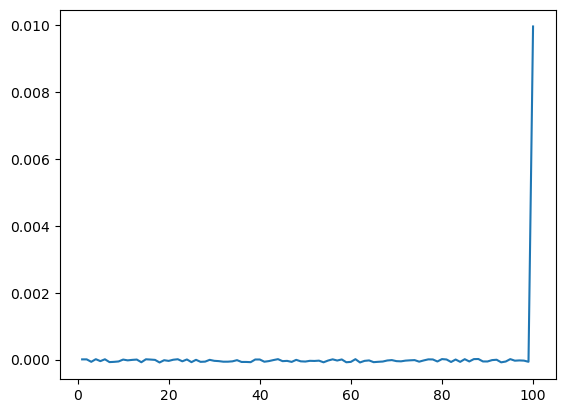

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2f7495b50>

In [141]:
plot(1:100, (rand(100, 100) + 100I) \ one(rand(100,100))[:,end])

In [134]:
(rand(100, 100) + 1I) \ one(rand(100,100))[:,end]

100-element Vector{Float64}:
  0.0016734284938963496
 -0.004873412282240887
  0.00024399063527789854
 -0.0011088442280594282
 -6.882105463369413e-5
 -0.002169293622009982
  2.9158319279035872e-5
  0.0002722436206289816
  0.0046906055756326505
 -0.0019706800448094546
 -0.001896629749874448
 -7.653066781027511e-5
  0.00410928272366268
  ⋮
 -0.001981282044651007
 -0.0011614158000633772
  0.00328190852293823
  0.004143020340141302
 -0.003832874777589152
 -0.00025752999298743647
 -0.0035476289119486704
  0.0037032158041894504
  0.00022916567750522014
 -0.0011052897890164526
 -0.0034341143466252045
  0.0963370982165279

In [198]:

function invR(A)
    if size(A)[1] != size(A)[2]
        return A' * inv(A * A')
    else
        return inv(A)
    end
end
function invL(A)
    if size(A)[1] != size(A)[2]
        return inv(A' * A) * A'
    else
        return inv(A)
    end
end

function invBlockBiU(U, bw) # have problem
    n = size(U)[2]
    r = rem(n, bw)
    T = eltype(U)
    E_k = zeros(T, n, bw)
    E_k[n-bw+1:n, :] = one(U[n-bw+1:n, n-bw+1:n])
    # X = qr(U) \ E_k
    # if typeof(U) == BandedMatrix
        X = qr(U) \ E_k
    #     print(11111111111111111)
    # else
        # X = U \ E_k
    Yt = zeros(T, bw, n)
    for i in n : -bw : r+bw
        Di = U[i-bw+1:i, i-bw+1:i]
        Xi = X[i-bw+1:i, :]
        # if typeof(U) == BandedMatrix
            Yti = qr(Di * Xi) \ I
        # else
            # Yti = inv(Di * Xi)
            
        # Yti = qr(Di * Xi) \ I
        # Yti = inv(Di * Xi)
        Yt[:, i-bw+1:i] = Yti
    end
    D0 = U[1:r, 1:r]
    # D0inv = qr(D0) \ I
    X0 = X[1:r, :]
    Yt0 = invR(D0 * X0)
    Yt[:, 1:r] = Yt0
    Uinv = triu(X * Yt)
    Uinv
end


invBlockBiU (generic function with 1 method)

In [206]:
include("genTestMat.jl")

n = 1000
bw = 2
U = generateTestTriangular(n, bw, BandedMatrix, BigFloat)

# U = generateTestTriangular(n, bw, UpperTriangular, BigFloat)
# U = generateTestTriangular(n, bw, Matrix, BigFloat)
# U = generateTestTriangular(n, bw, Bidiagonal, BigFloat)
# Bidiagonal
# display(U)
display(typeof(U))
# U = generateTestTriangular(n, bw, Bidiagonal, Float64)
# U = generateTestTriangular(n, bw, BandedMatrix, Float64)


Uinv = invBlockBiU(U, bw)
II = U * Uinv
# display(II)
display(II ≈ I)
norm(II - I)

# invBidiagU(U)

BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}

false

6.52160475290256761666715646758864085342787655731736573052000100001317459915963e-15

In [197]:
x = rand(n)

b = U * x

x1 = Uinv * b
norm(x - x1)


II[1:10, 1:10]

10×10 Matrix{BigFloat}:
 1.0  4.17612e-06  -8.10128e-07  0.0          …   0.0          0.0
 0.0  1.00492      -0.00140571   7.35062e-06      0.0          0.0
 0.0  0.0           1.00032      3.95996e-06      0.0          0.0
 0.0  0.0           0.0          1.00002          0.0          0.0
 0.0  0.0           0.0          0.0              3.00249e-07  0.0
 0.0  0.0           0.0          0.0          …  -1.45409e-07  0.0
 0.0  0.0           0.0          0.0              1.76355e-06  0.0
 0.0  0.0           0.0          0.0             -0.00219096   6.44986e-06
 0.0  0.0           0.0          0.0              0.998953     1.43187e-06
 0.0  0.0           0.0          0.0              0.0          1.0

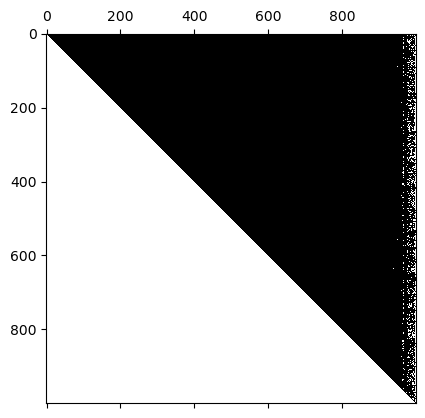

PyObject <matplotlib.image.AxesImage object at 0x3b3a6ca30>

In [190]:
spy(II)

In [191]:
map!(x -> isapprox(x, 0, atol=1e-8) ? 0 : x, II, II)

1000×1000 Matrix{BigFloat}:
 1.0  4.17612e-06  -8.10128e-07  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.00492      -0.00140571      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           1.00032         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                               ⋱            ⋮               

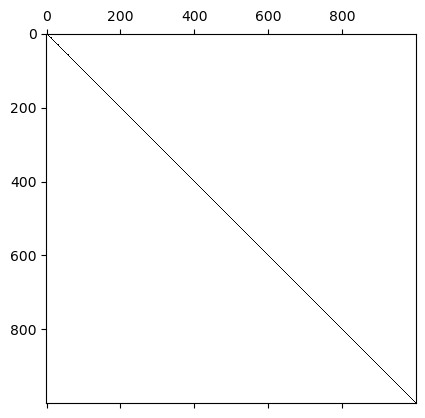

PyObject <matplotlib.image.AxesImage object at 0x3af001c10>

In [192]:
spy(II)

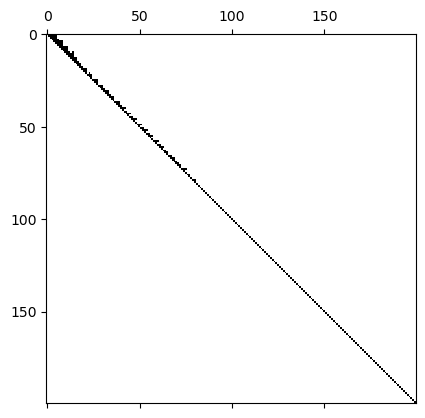

PyObject <matplotlib.image.AxesImage object at 0x3b037e670>

In [193]:
spy(II[1:200, 1:200])

In [14]:
n = 100
T = Tridiagonal(-ones(n-1), 4*ones(n), -ones(n-1))
display(T)
T = Matrix(T)
isposdef(T)
C = cholesky(T)
L = C.L
U = C.U

100×100 Tridiagonal{Float64, Vector{Float64}}:
  4.0  -1.0    ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -1.0   4.0  -1.0    ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0   4.0  -1.0    ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -1.0   4.0  -1.0    ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -1.0   4.0  -1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -1.0   4.0  …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅    

100×100 UpperTriangular{Float64, Matrix{Float64}}:
 2.0  -0.5       0.0        0.0       …   0.0        0.0        0.0
  ⋅    1.93649  -0.516398   0.0           0.0        0.0        0.0
  ⋅     ⋅        1.93218   -0.517549      0.0        0.0        0.0
  ⋅     ⋅         ⋅         1.93188       0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅        …   0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅        …   0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
 ⋮                                    ⋱                        
 

In [13]:
L

100×100 LowerTriangular{Float64, Matrix{Float64}}:
  2.0    ⋅          ⋅          ⋅        …    ⋅          ⋅         ⋅ 
 -0.5   1.93649     ⋅          ⋅             ⋅          ⋅         ⋅ 
  0.0  -0.516398   1.93218     ⋅             ⋅          ⋅         ⋅ 
  0.0   0.0       -0.517549   1.93188        ⋅          ⋅         ⋅ 
  0.0   0.0        0.0       -0.517632       ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0       …    ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0            ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0            ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0            ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0            ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0       …    ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0            ⋅          ⋅         ⋅ 
  0.0   0.0        0.0        0.0            ⋅          ⋅         ⋅ 
  ⋮                                     ⋱           

In [11]:
U

10×10 UpperTriangular{Float64, Matrix{Float64}}:
 2.0  -0.5       0.0        0.0       …   0.0        0.0        0.0
  ⋅    1.93649  -0.516398   0.0           0.0        0.0        0.0
  ⋅     ⋅        1.93218   -0.517549      0.0        0.0        0.0
  ⋅     ⋅         ⋅         1.93188       0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅            0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅        …   0.0        0.0        0.0
  ⋅     ⋅         ⋅          ⋅           -0.517638   0.0        0.0
  ⋅     ⋅         ⋅          ⋅            1.93185   -0.517638   0.0
  ⋅     ⋅         ⋅          ⋅             ⋅         1.93185   -0.517638
  ⋅     ⋅         ⋅          ⋅             ⋅          ⋅         1.93185

In [17]:
Bidiagonal(ones(3), ones(2), :U)

3×3 Bidiagonal{Float64, Vector{Float64}}:
 1.0  1.0   ⋅ 
  ⋅   1.0  1.0
  ⋅    ⋅   1.0

In [18]:
n = 32
A = Tridiagonal(-1ones(n-1), 4ones(n), -1ones(n-1))
T = Matrix(A)
isposdef(T)
C = cholesky(T)
L = C.L
U = C.U
L * L' ≈ T
U' * U ≈ T

true

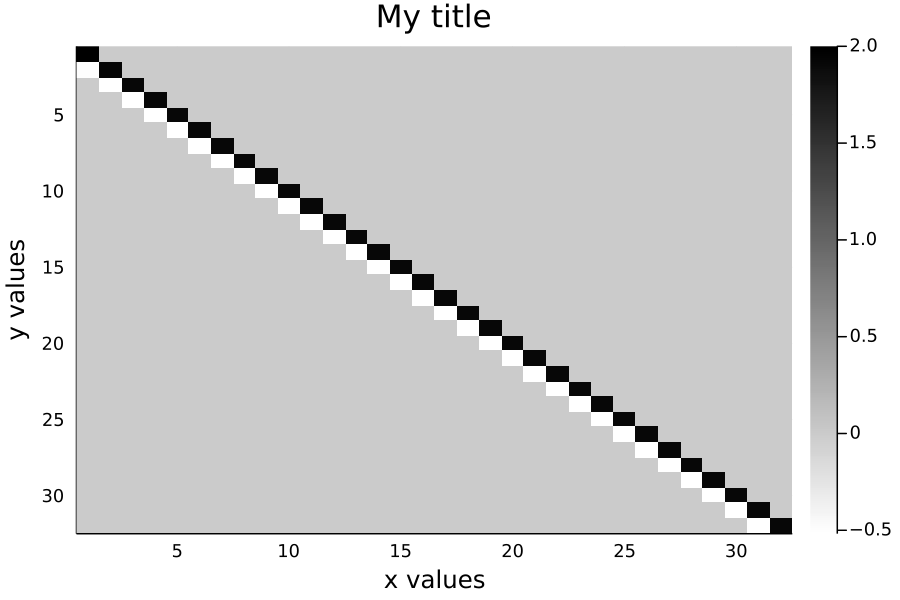

In [19]:
using Plots, ColorSchemes, LaTeXStrings


L
gr()

data = L
# display(data)
fig1 = heatmap(1:size(data,2),
    1:size(data,1), data,
    c=cgrad([:white, :black]),
    xlabel="x values", ylabel="y values",
    title="My title", dpi=150, yflip=true)
display(fig1)

In [9]:
U

6×6 UpperTriangular{Float64, Matrix{Float64}}:
 2.0  -0.5       0.0        0.0        0.0        0.0
  ⋅    1.93649  -0.516398   0.0        0.0        0.0
  ⋅     ⋅        1.93218   -0.517549   0.0        0.0
  ⋅     ⋅         ⋅         1.93188   -0.517632   0.0
  ⋅     ⋅         ⋅          ⋅         1.93185   -0.517638
  ⋅     ⋅         ⋅          ⋅          ⋅         1.93185

In [14]:
UU = Bidiagonal(2ones(n),-ones(n-1),:U)
UU' * UU

6×6 SparseArrays.SparseMatrixCSC{Float64, Int64} with 16 stored entries:
  4.0  -2.0    ⋅     ⋅     ⋅     ⋅ 
 -2.0   5.0  -2.0    ⋅     ⋅     ⋅ 
   ⋅   -2.0   5.0  -2.0    ⋅     ⋅ 
   ⋅     ⋅   -2.0   5.0  -2.0    ⋅ 
   ⋅     ⋅     ⋅   -2.0   5.0  -2.0
   ⋅     ⋅     ⋅     ⋅   -2.0   5.0

In [24]:
dd0 = symbols("d_(1:11)", real=True)
d = [i for i in dd0]

bb0 = symbols("b_(1:11)", real=True)
b = [i for i in bb0]




# yy0 = symbols("y_(1:6)", real=True)
# uu0 = symbols("u_(1:6)", real=True)
# vv0 = symbols("v_(1:6)", real=True)
# pp0 = symbols("p_(1:6)", real=True)
# qq0 = symbols("q_(1:6)", real=True)
# ds = [i for i in dd0]
# ys = [i for i in yy0]
# us = [i for i in uu0]
# vs = [i for i in vv0]
# ps = [i for i in pp0]
# qs = [i for i in qq0]

10-element Vector{Sym}:
  b_1
  b_2
  b_3
  b_4
  b_5
  b_6
  b_7
  b_8
  b_9
 b_10

In [65]:
n = 10

k = 5

ns = symbols("n", real=True, positive=True)
ks = symbols("k", real=True, positive=True)

r = symbols("r", real=True, positive=True)






dmax = symbols("d_max", real=True, positive=True)
dmin = symbols("d_min", real=True, positive=True)
bmax = symbols("b_max", real=True, negative=True)
bmin = symbols("b_min", real=True, negative=True)

rmax = -dmax/bmin
rmin = -dmin/bmax

rmax*(1-(dmin^2*rmin^(2*(ns-ks))) / dmax^2*(ns-ks+1)*rmax^(2*(ns-ks)))



# simplify(r*(1+r^2*((r^2-1)*(r^(2*ns))) / (r^(2*ks) - r^(2*(ns+1)))))

r*(1+r^2*((r^2-1)*(r^(2*ns))) / (r^(2*ks) - r^(2*(ns+1))))

  / 2  2*n / 2    \    \
  |r *r   *\r  - 1/    |
r*|---------------- + 1|
  | 2*k    2*n + 2     |
  \r    - r            /

In [31]:

ans2 = 0
for l in k:n
ans1 = 1
ans1 /= d[l]^2
    for i in l:n-1
        ans1 *= (-d[i]/b[i])^2
    end
    ans2+=ans1

end
ans2

                     2          2    2            2    2    2          2    2 
  1      1        d_9        d_8 *d_9          d_7 *d_8 *d_9        d_6 *d_7 *
----- + ---- + --------- + -------------- + ------------------- + ------------
    2      2      2    2      2    2    2      2    2    2    2      2    2   
d_10    b_9    b_8 *b_9    b_7 *b_8 *b_9    b_6 *b_7 *b_8 *b_9    b_5 *b_6 *b_

   2    2   
d_8 *d_9    
------------
 2    2    2
7 *b_8 *b_9 

In [34]:
ans3 = 1
ans3 /= d[k]^2
for i in k:n-1
    ans3 *= (-d[i]/b[i])^2
end
ans3

     2    2    2    2   
  d_6 *d_7 *d_8 *d_9    
------------------------
   2    2    2    2    2
b_5 *b_6 *b_7 *b_8 *b_9 

In [40]:
factor((1- ans3 / ans2)*(-d[k]/b[k]))

                             /   2    2    2    2      2    2    2     2      
                    -b_5*d_5*\b_6 *b_7 *b_8 *b_9  + b_6 *b_7 *b_8 *d_10  + b_6
------------------------------------------------------------------------------
   2    2    2    2    2      2    2    2    2     2      2    2    2     2   
b_5 *b_6 *b_7 *b_8 *b_9  + b_5 *b_6 *b_7 *b_8 *d_10  + b_5 *b_6 *b_7 *d_10 *d_

2    2     2    2      2     2    2    2       2    2    2    2\              
 *b_7 *d_10 *d_9  + b_6 *d_10 *d_8 *d_9  + d_10 *d_7 *d_8 *d_9 /              
------------------------------------------------------------------------------
 2      2    2     2    2    2      2     2    2    2    2       2    2    2  
9  + b_5 *b_6 *d_10 *d_8 *d_9  + b_5 *d_10 *d_7 *d_8 *d_9  + d_10 *d_6 *d_7 *d

        
        
--------
  2    2
_8 *d_9 